## Review and Improvement: Exploring the notebook [RSS_Modelling_DNN.ipynb](https://github.com/bmw-ece-ntust/AP-localization-regression/blob/master/2024_NTUST/IPYNB/RSS_Modelling_DNN.ipynb)

In [1]:
import time 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

import optuna
from xgboost import XGBClassifier
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

## InfluxDB Data Mounting

## Repo Existing data
#### HASH locations method

In [2]:
path = 'data/full_rss_d1_v2.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0'])

In [3]:
# new step: NaN convertion
## old: float(np.iinfo(np.int32).max
data.replace({np.nan: 100}, inplace=True)

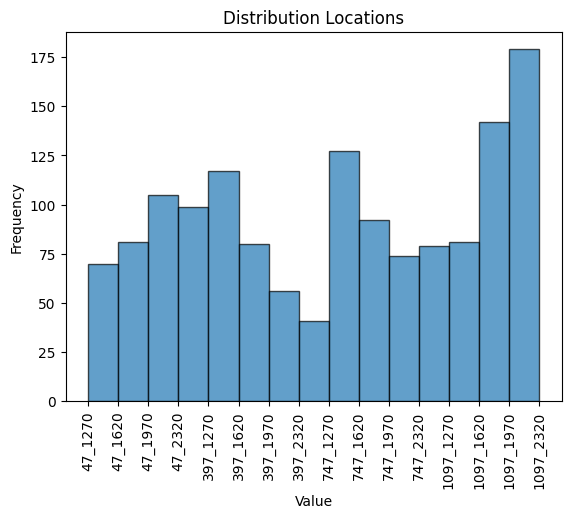

In [4]:
# new step: Create a postion "hash"

# sort values for location
data = data.sort_values(by=['xr', 'yr'], ascending=[True, True])

## Create a new colum with both values 
data['pair'] = data['xr'].astype(int).astype(str) + '_' + data['yr'].astype(int).astype(str)

plt.hist(data['pair'], bins=len(set(data['pair']))-1, edgecolor='k', alpha=0.7)
plt.title('Distribution Locations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

## Label Encode them to one single value 
le = LabelEncoder()
data['label'] = le.fit_transform(data['pair'])

## Drop columns that will not be used for training
data = data.drop(columns=['Long', 'Lat', 'xr', 'yr', 'pair'])

In [5]:
data

,rssi_D1_1F_AP01,rssi_D1_1F_AP02,rssi_D1_1F_AP03,rssi_D1_1F_AP04,rssi_D1_1F_AP05,rssi_D1_1F_AP06,rssi_D1_1F_AP07,rssi_D1_1F_AP08,label
0,100.0,100.0,100.0,93.0,100.0,100.0,100.0,100.0,8
1,100.0,100.0,100.0,93.0,55.0,100.0,100.0,100.0,8
2,100.0,100.0,100.0,92.0,100.0,100.0,100.0,100.0,8
3,100.0,100.0,100.0,92.0,56.0,100.0,100.0,100.0,8
4,100.0,100.0,100.0,93.0,56.0,100.0,100.0,100.0,8
...,...,...,...,...,...,...,...,...,...
1418,100.0,87.0,100.0,100.0,32.0,100.0,100.0,100.0,3
1419,100.0,88.0,100.0,100.0,33.0,100.0,100.0,100.0,3
1420,100.0,89.0,100.0,100.0,100.0,100.0,100.0,100.0,3
1421,100.0,88.0,100.0,100.0,33.0,100.0,100.0,100.0,3


## Data Augementation (Skip)

## Data Distribution

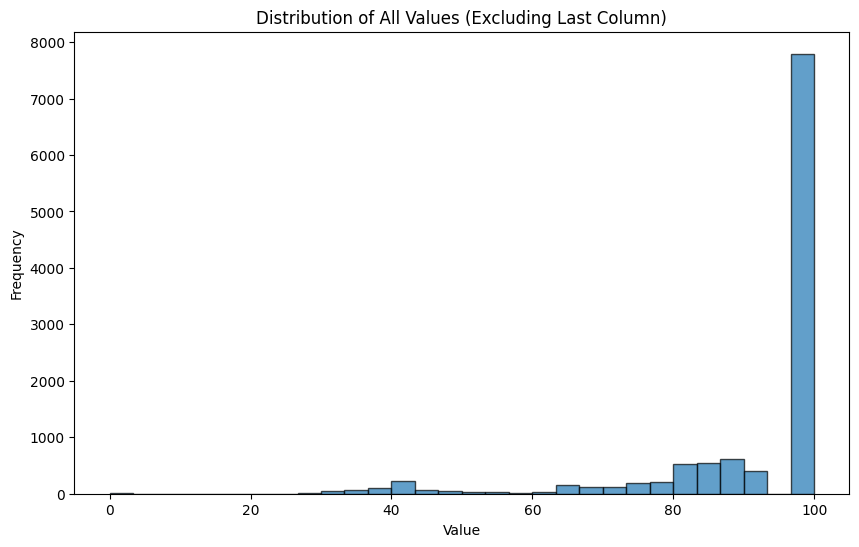

In [6]:
# Plot the distribution of each column
values = data.iloc[:, :-1].values.flatten()
plt.figure(figsize=(10, 6))
plt.hist(values, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of All Values (Excluding Last Column)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Scaling using Robust Scaler

In [7]:
X = data.iloc[:, :-1] 
y = data.iloc[:, -1]  

In [8]:
robust_scaled_data = RobustScaler().fit_transform(X)

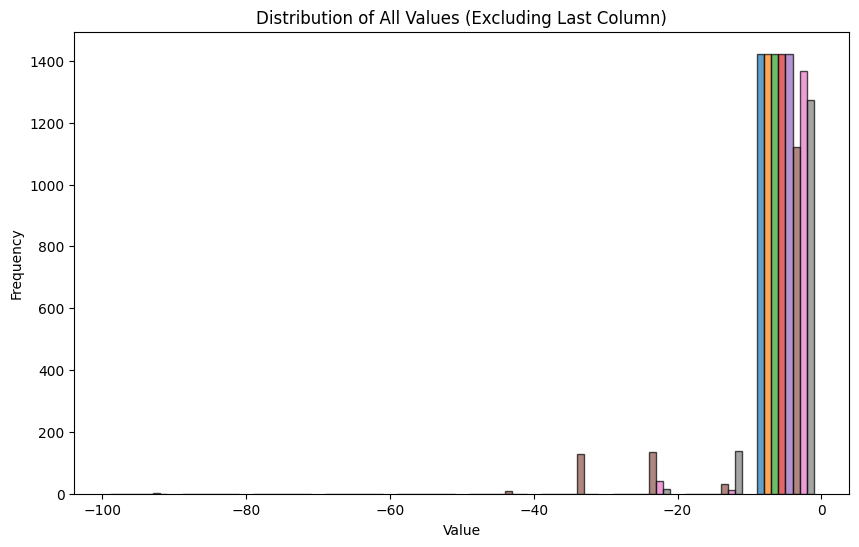

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(robust_scaled_data, edgecolor='k', alpha=0.7)
plt.title('Distribution of All Values (Excluding Last Column)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

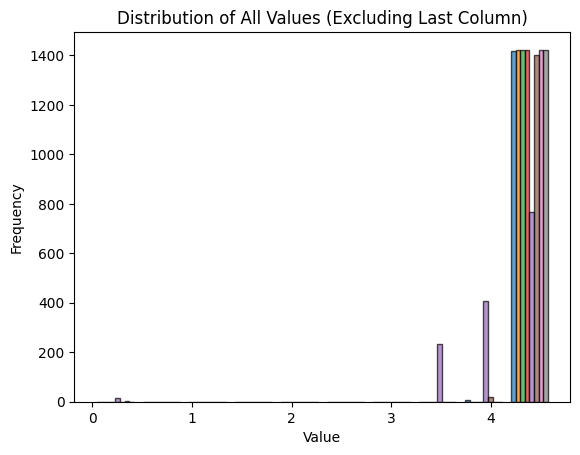

In [10]:
log_transofmed_data = np.log1p(X)
plt.hist(log_transofmed_data, edgecolor='k', alpha=0.7)
plt.title('Distribution of All Values (Excluding Last Column)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

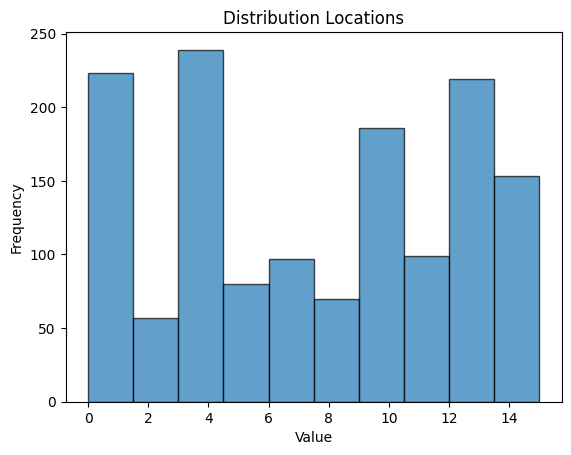

In [11]:
plt.hist(y, edgecolor='k', alpha=0.7)
plt.title('Distribution Locations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

#### Are there overlapping points in the data?

In [34]:
data

,rssi_D1_1F_AP01,rssi_D1_1F_AP02,rssi_D1_1F_AP03,rssi_D1_1F_AP04,rssi_D1_1F_AP05,rssi_D1_1F_AP06,rssi_D1_1F_AP07,rssi_D1_1F_AP08,label
0,100.0,100.0,100.0,93.0,100.0,100.0,100.0,100.0,8
1,100.0,100.0,100.0,93.0,55.0,100.0,100.0,100.0,8
2,100.0,100.0,100.0,92.0,100.0,100.0,100.0,100.0,8
3,100.0,100.0,100.0,92.0,56.0,100.0,100.0,100.0,8
4,100.0,100.0,100.0,93.0,56.0,100.0,100.0,100.0,8
...,...,...,...,...,...,...,...,...,...
1418,100.0,87.0,100.0,100.0,32.0,100.0,100.0,100.0,3
1419,100.0,88.0,100.0,100.0,33.0,100.0,100.0,100.0,3
1420,100.0,89.0,100.0,100.0,100.0,100.0,100.0,100.0,3
1421,100.0,88.0,100.0,100.0,33.0,100.0,100.0,100.0,3


In [39]:
binned_data = data.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

label
rssi_D1_1F_AP01 rssi_D1_1F_AP02 rssi_D1_1F_AP03 rssi_D1_1F_AP04 rssi_D1_1F_AP05 rssi_D1_1F_AP06 rssi_D1_1F_AP07 rssi_D1_1F_AP08       
64.0            100.0           100.0           100.0           100.0           100.0           100.0           100.0               15
                                                                                                                100.0               15
                                                                                                                100.0                0
                                                                                                                100.0                0
                                                                                                                100.0                1
...                                                                                                                                ...
100.0           100.0           100.0           100.0           100.0           100.0           100.0           90.0                12
                                                                                                                90.0                12
                                                                                                                90.0                12
                                                                                                                90.0                12
                                                                                                                90.0                12

[367 rows x 1 columns]

In [42]:
# Identify groups with more than one unique label (overlapping points)
overlapping_groups = overlapping_points[overlapping_points > 1].index

# Filter the original data that corresponds to these overlapping groups
# Find the original rows corresponding to the overlapping points
overlapping_data = binned_data[binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_groups)]

# Now, get the original data corresponding to these overlapping points
original_overlapping_data = data.loc[overlapping_data.index]

# Remove duplicates in the original data by keeping the first occurrence
deduplicated_data = original_overlapping_data.drop_duplicates(subset=list(data.columns[:-1]), keep='first')

# Combine non-overlapping data with the deduplicated overlapping data
non_overlapping_data = data.drop(index=original_overlapping_data.index)
nond_data = pd.concat([non_overlapping_data, deduplicated_data]).reset_index(drop=True)

nond_data

,rssi_D1_1F_AP01,rssi_D1_1F_AP02,rssi_D1_1F_AP03,rssi_D1_1F_AP04,rssi_D1_1F_AP05,rssi_D1_1F_AP06,rssi_D1_1F_AP07,rssi_D1_1F_AP08,label
0,100.0,100.0,100.0,93.0,100.0,100.0,100.0,100.0,8
1,100.0,100.0,100.0,93.0,55.0,100.0,100.0,100.0,8
2,100.0,100.0,100.0,92.0,100.0,100.0,100.0,100.0,8
3,100.0,100.0,100.0,92.0,56.0,100.0,100.0,100.0,8
4,100.0,100.0,100.0,93.0,56.0,100.0,100.0,100.0,8
...,...,...,...,...,...,...,...,...,...
1126,100.0,100.0,100.0,100.0,33.0,100.0,100.0,100.0,15
1127,100.0,100.0,89.0,100.0,100.0,100.0,100.0,100.0,0
1128,66.0,83.0,88.0,100.0,100.0,100.0,100.0,100.0,0
1129,100.0,100.0,100.0,88.0,39.0,100.0,100.0,100.0,1


In [43]:
x_nond_data_rs = RobustScaler().fit_transform(nond_data.iloc[:, :-1])
y_nond_data_rs = nond_data.iloc[:, -1]

## Model XGBClassifier With LogScaling

In [12]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = CustomDataset(log_transofmed_data, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(log_transofmed_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [14]:
y_train.size, y_val.size, y_test.size

(1001, 137, 285)

In [15]:
# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False)

# Train the model
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.81      0.71      0.76        35
           2       1.00      1.00      1.00         5
           3       0.59      0.76      0.67        21
           4       0.55      0.63      0.59        19
           5       0.71      0.59      0.65        17
           6       0.24      0.40      0.30        10
           7       0.75      0.67      0.71         9
           8       1.00      1.00      1.00        11
           9       0.82      0.45      0.58        20
          10       0.77      0.89      0.83        19
          11       0.56      0.43      0.49        23
          12       0.65      0.81      0.72        27
          13       0.57      0.59      0.58        22
          14       0.78      0.47      0.58        15
          15       0.76      0.87      0.81        15

    accuracy                           0.6

In [17]:
def decode(data):
    decoded_data = le.inverse_transform(data)
    xr, yr = zip(*[(float(x), float(y)) for x, y in (item.split('_') for item in decoded_data)])
    return xr, yr

In [18]:
xd_pred, yd_pred = decode(y_pred) 
xd_test, yd_test = decode(y_test)

In [19]:
def single_plot(x, y):
    plt.scatter(x, y, c='blue', marker='o')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scatter Plot of x and y Positions')

    plt.grid(True)
    plt.show()
    
def combined_plot(xd_pred, yd_pred, xd_test, yd_test):
    correct = [(x_pred == x_true) and (y_pred == y_true) 
            for (x_pred, y_pred), (x_true, y_true) in zip(zip(xd_pred, yd_pred), zip(xd_test, yd_test))]

    correct = np.array(correct)


    plt.figure(figsize=(10, 6))

    # Plot ground truth
    plt.scatter(xd_test, yd_test, c='green', marker='o', s=200, alpha=0.5, label='Ground Truth')

    # Plot predictions
    plt.scatter(np.array(xd_pred)[correct], np.array(yd_pred)[correct], c='blue', marker='o', s=50, alpha=0.2, label='Correct Predictions')
    plt.scatter(np.array(xd_pred)[~correct], np.array(yd_pred)[~correct], c='red', marker='o', s=50, alpha=0.2, label='Incorrect Predictions')

    # Calculate percentages
    total_points = len(correct)
    correct_percentage = 100 * np.sum(correct) / total_points
    incorrect_percentage = 100 * (total_points - np.sum(correct)) / total_points

    plt.legend(title=f'Correct: {correct_percentage:.2f}%\nIncorrect: {incorrect_percentage:.2f}%', bbox_to_anchor=(1, 1), loc='upper left')

    plt.xlabel('xr')
    plt.ylabel('yr')
    plt.title('Scatter Plot of x and y Positions')

    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

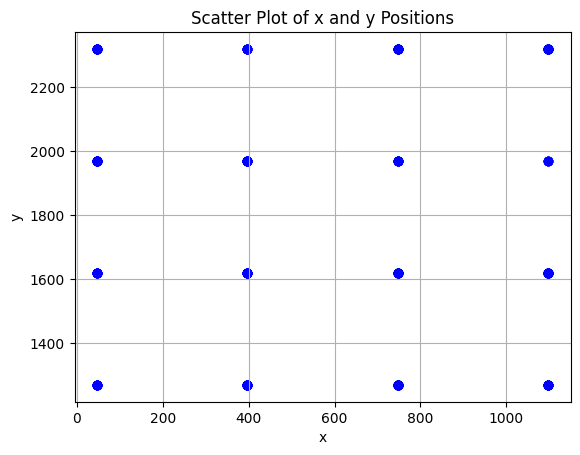

In [20]:
single_plot(xd_pred, yd_pred)

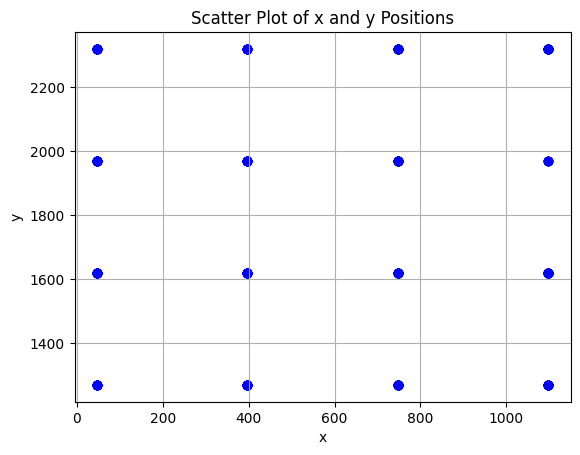

In [21]:
single_plot(xd_test, yd_test)

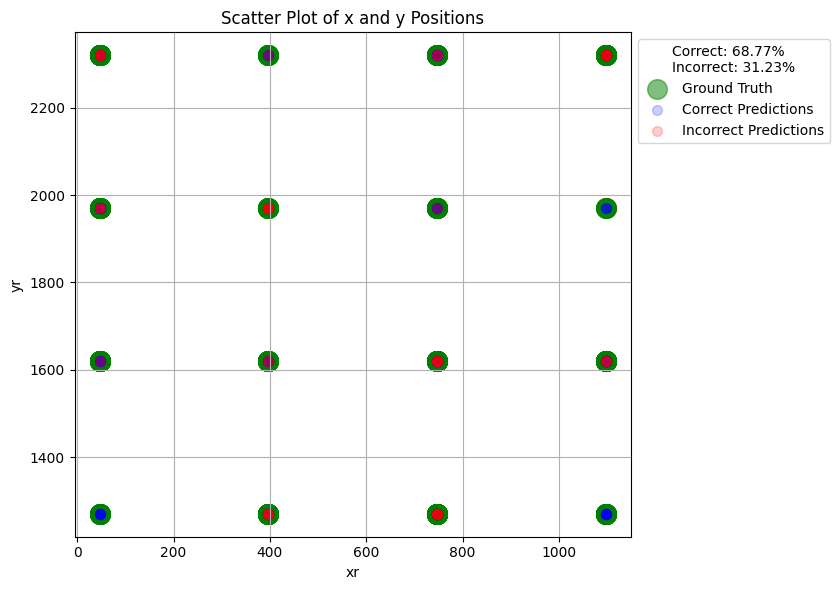

In [22]:
combined_plot(xd_pred, yd_pred, xd_test, yd_test)

## Model XGBClassifier With Robust Scaler 

In [23]:
## Dataset creation 
dataset = CustomDataset(robust_scaled_data, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

X_train, X_test, y_train, y_test = train_test_split(log_transofmed_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [24]:
## Train model
xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.81      0.71      0.76        35
           2       1.00      1.00      1.00         5
           3       0.59      0.76      0.67        21
           4       0.55      0.63      0.59        19
           5       0.71      0.59      0.65        17
           6       0.24      0.40      0.30        10
           7       0.75      0.67      0.71         9
           8       1.00      1.00      1.00        11
           9       0.82      0.45      0.58        20
          10       0.77      0.89      0.83        19
          11       0.56      0.43      0.49        23
          12       0.65      0.81      0.72        27
          13       0.57      0.59      0.58        22
          14       0.78      0.47      0.58        15
          15       0.76      0.87      0.81        15

    accuracy                           0.6

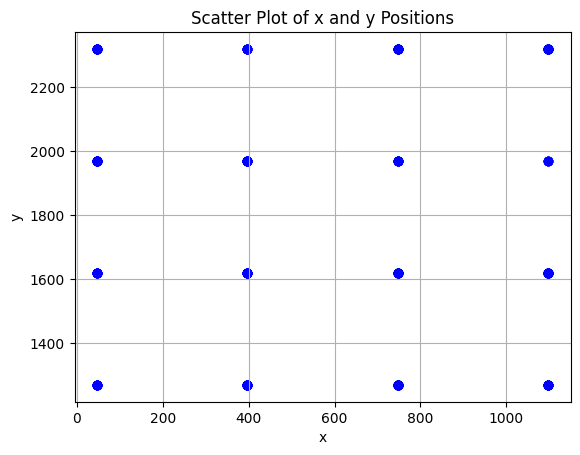

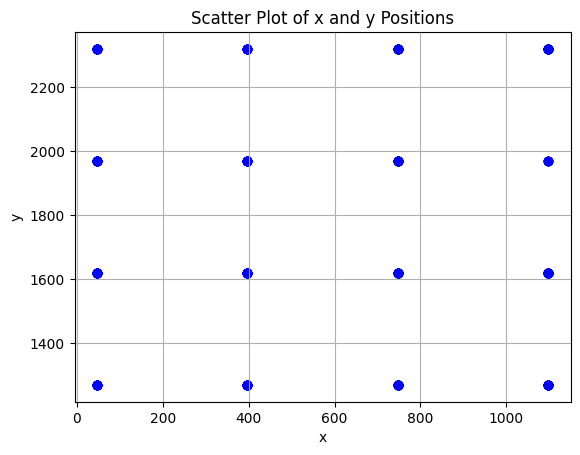

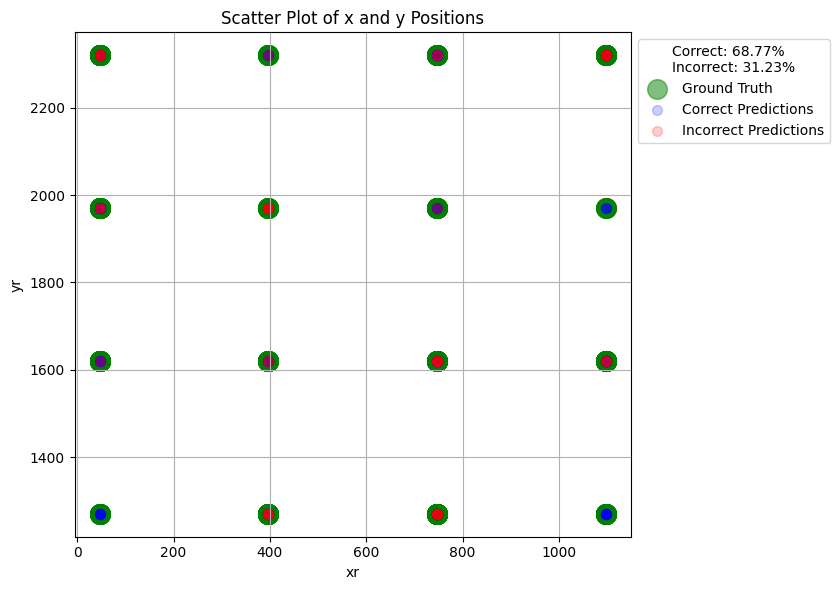

In [25]:
## Make plots
xd_pred, yd_pred = decode(y_pred) 
xd_test, yd_test = decode(y_test)

single_plot(xd_pred, yd_pred)
single_plot(xd_test, yd_test)
combined_plot(xd_pred, yd_pred, xd_test, yd_test)

## Finding best parameters for XGBoost

In [29]:
from sklearn.model_selection import GridSearchCV

# Define the model
xgb_clf = XGBClassifier(use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.4],
    'max_depth': [3, 6, 9],
    #'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best score: 0.6682910455365545


In [31]:
best_xgb_clf = XGBClassifier(**grid_search.best_params_, use_label_encoder=False)
best_xgb_clf.fit(X_train, y_train)

y_pred = best_xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.83      0.71      0.77        35
           2       1.00      1.00      1.00         5
           3       0.63      0.81      0.71        21
           4       0.56      0.53      0.54        19
           5       0.79      0.65      0.71        17
           6       0.29      0.40      0.33        10
           7       1.00      0.67      0.80         9
           8       1.00      1.00      1.00        11
           9       0.76      0.65      0.70        20
          10       0.77      0.89      0.83        19
          11       0.62      0.57      0.59        23
          12       0.57      0.74      0.65        27
          13       0.58      0.64      0.61        22
          14       0.86      0.40      0.55        15
          15       0.72      0.87      0.79        15

    accuracy                           0.7

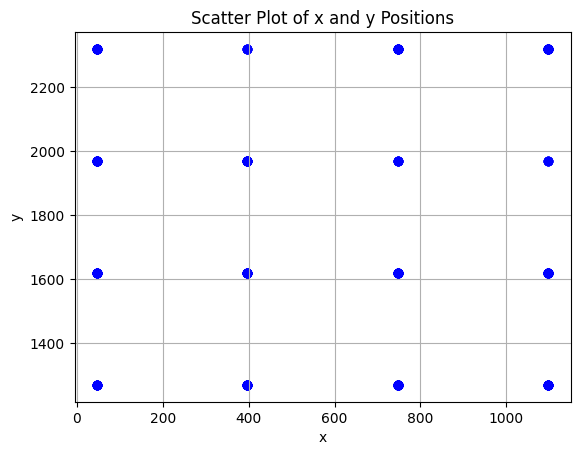

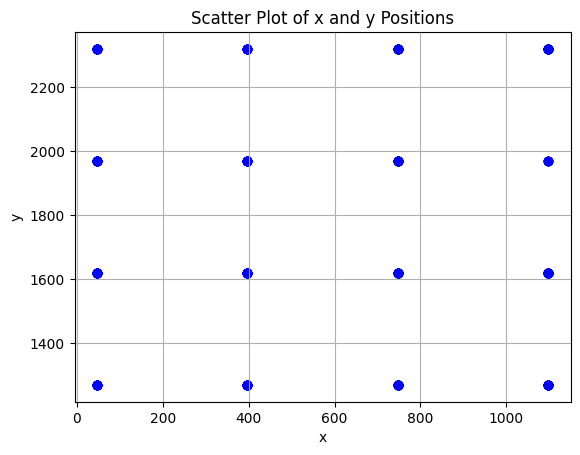

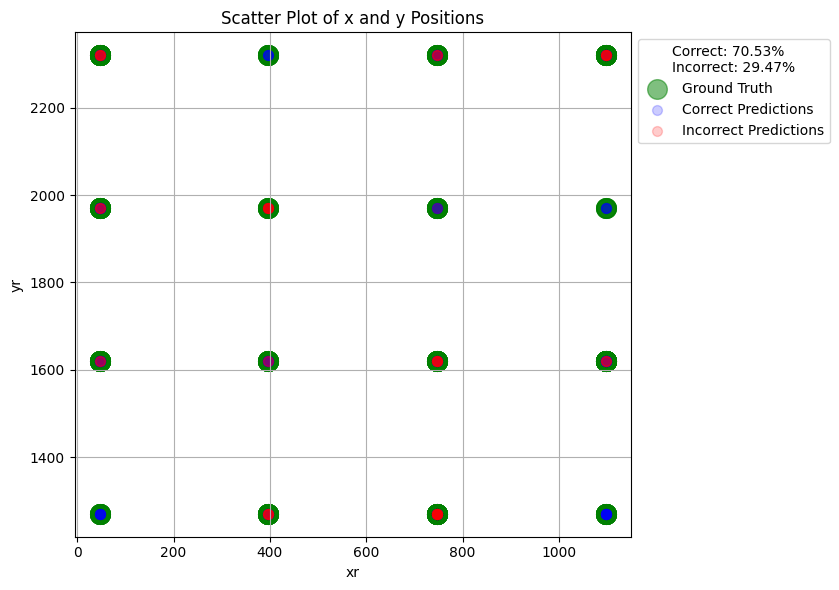

In [32]:
## Make plots
xd_pred, yd_pred = decode(y_pred) 
xd_test, yd_test = decode(y_test)

single_plot(xd_pred, yd_pred)
single_plot(xd_test, yd_test)
combined_plot(xd_pred, yd_pred, xd_test, yd_test)

## Best XGBoost with non Duplicated data

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x_nond_data_rs, y_nond_data_rs, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

best_xgb_clf = XGBClassifier(**grid_search.best_params_, use_label_encoder=False)
best_xgb_clf.fit(X_train, y_train)

y_pred = best_xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        21
           1       0.83      0.77      0.80        26
           2       1.00      0.71      0.83         7
           3       0.92      0.92      0.92        13
           4       0.83      0.62      0.71        16
           5       0.89      0.67      0.76        12
           6       0.62      0.62      0.62         8
           7       0.75      0.75      0.75         4
           8       1.00      1.00      1.00        12
           9       0.79      0.75      0.77        20
          10       0.81      0.96      0.88        23
          11       0.86      0.92      0.89        13
          12       0.76      0.94      0.84        17
          13       0.88      0.78      0.82         9
          14       0.56      0.62      0.59         8
          15       0.88      0.83      0.86        18

    accuracy                           0.8

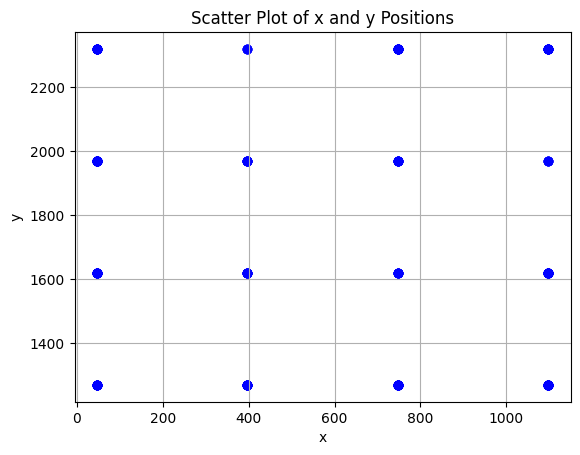

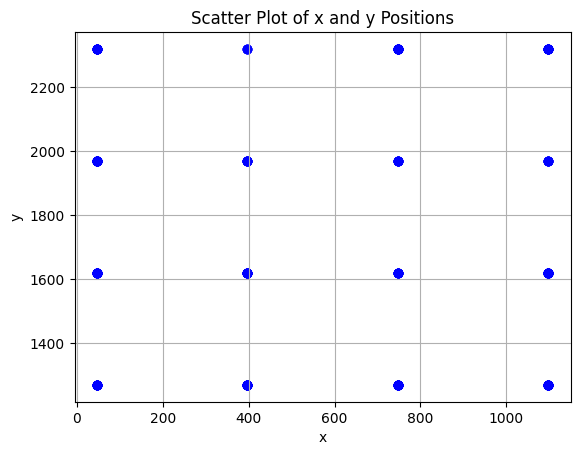

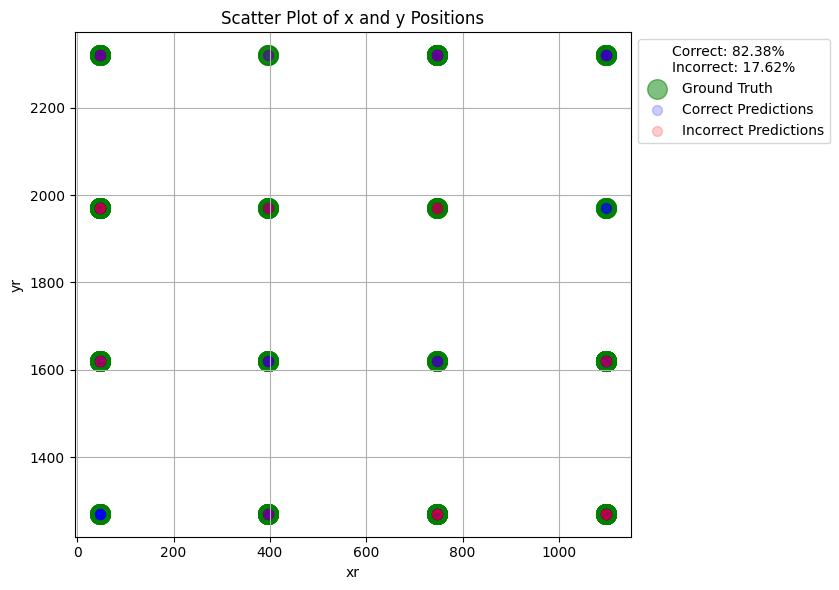

In [45]:
## Make plots
xd_pred, yd_pred = decode(y_pred) 
xd_test, yd_test = decode(y_test)

single_plot(xd_pred, yd_pred)
single_plot(xd_test, yd_test)
combined_plot(xd_pred, yd_pred, xd_test, yd_test)

## Using MLP

In [58]:
def evaluate(model, data_loader, criterion, accuracy=False):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    total_mse = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            
            # Classification case (CrossEntropyLoss or similar)
            if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
                if len(labels.shape) > 1 and labels.shape[1] > 1:  # One-hot encoded labels
                    labels = torch.argmax(labels, dim=1)

                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                # Compute accuracy
                if accuracy:
                    preds = torch.argmax(outputs, dim=1)
                    total_correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

            # Regression case (MSELoss or similar)
            elif isinstance(criterion, nn.MSELoss) or isinstance(criterion, nn.L1Loss):
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                # Compute Mean Squared Error
                mse = torch.mean((outputs - labels) ** 2).item()
                total_mse += mse * labels.size(0)
                total_samples += labels.size(0)
    
    # Return accuracy for classification tasks
    if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
        accuracy = total_correct / total_samples * 100
        return accuracy
    
    # Return Mean Squared Error for regression tasks
    elif isinstance(criterion, nn.MSELoss) or isinstance(criterion, nn.L1Loss):
        mse = total_mse / total_samples
        return mse

In [59]:
def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, val_interval):
    epochs = range(1, num_epochs + 1)
    val_epochs = [i * val_interval for i in range(len(val_accuracies))]
    
    plt.figure(figsize=(14, 6))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    if val_losses:
        plt.plot(val_epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    if val_accuracies:
        plt.plot(val_epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [60]:
def train(model, train_loader, optimizer, criterion, num_epochs, val_loader=None, val_interval=1, print_interval=1):
    
    train_losses = []
    val_losses = []
    train_metrics = []
    val_metrics = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            optimizer.zero_grad()
            
            outputs = model(inputs)

            # Calculate loss and backpropagate
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Compute training metrics (accuracy for classification, MSE for regression)
        train_metric = evaluate(model, train_loader, criterion=criterion, accuracy=True)
        train_metrics.append(train_metric)
                    
        if val_loader is not None and (epoch + 1) % val_interval == 0:
            model.eval()
            val_running_loss = 0.0
            
            # Validation loop
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
            
            avg_val_loss = val_running_loss / len(val_loader)
            val_losses.append(avg_val_loss)
         
            # Compute validation metrics (accuracy for classification, MSE for regression)
            val_metric = evaluate(model, val_loader, criterion=criterion, accuracy=True)
            val_metrics.append(val_metric)
            
        # Print average loss and validation results at specified intervals
        if (epoch + 1) % print_interval == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}')
            
            if val_loader is not None:
                print(f'Validation Loss: {avg_val_loss:.4f}')
                
                # Display accuracy for classification or MSE for regression
                if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
                    print(f'Validation Accuracy: {val_metric:.2f}%')
                elif isinstance(criterion, nn.MSELoss) or isinstance(criterion, nn.L1Loss):
                    print(f'Validation MSE: {val_metric:.4f}')
    
    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_metrics, val_metrics, num_epochs, val_interval)

In [61]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 256)   
        self.hidden2 = nn.Linear(256, 128)          
        self.hidden3 = nn.Linear(128, 64)           
        self.output = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)            

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)                        
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)                        
        x = self.relu(self.hidden3(x))
        x = self.output(x)
        return x

In [48]:
# Model parameters
batch_size = 1024 
num_epochs = 5000
learning_rate= 0.001


In [49]:
# get the number of AP in the trainig data
num_classes = len(set(y))

X_train, X_test, y_train, y_test = train_test_split(log_transofmed_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# transform the data to torch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)

y_train_one_hot = F.one_hot(torch.tensor(y_train.to_numpy(), dtype=torch.long), num_classes=num_classes).float()
y_test_one_hot = F.one_hot(torch.tensor(y_test.to_numpy(), dtype=torch.long), num_classes=num_classes).float()
y_val_one_hot = F.one_hot(torch.tensor(y_val.to_numpy(), dtype=torch.long), num_classes=num_classes).float()

# Create the new torch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_one_hot)
test_dataset = TensorDataset(X_test_tensor, y_test_one_hot)
val_dataset = TensorDataset(X_val_tensor, y_val_one_hot)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [33]:
input_size = X_train_tensor.shape[1]
output_size = y_train_one_hot.shape[1]
model = MLP(input_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 500/5000, Training Loss: 1.7519
Validation Loss: 1.5726
Validation Accuracy: 48.18%


Epoch 1000/5000, Training Loss: 1.4381
Validation Loss: 1.3017
Validation Accuracy: 58.39%


Epoch 1500/5000, Training Loss: 1.2782
Validation Loss: 1.1767
Validation Accuracy: 63.50%


Epoch 2000/5000, Training Loss: 1.1760
Validation Loss: 1.1522
Validation Accuracy: 64.96%


Epoch 2500/5000, Training Loss: 1.1373
Validation Loss: 1.1249
Validation Accuracy: 62.04%


Epoch 3000/5000, Training Loss: 1.0469
Validation Loss: 1.1111
Validation Accuracy: 64.96%


Epoch 3500/5000, Training Loss: 1.0544
Validation Loss: 1.1290
Validation Accuracy: 65.69%


Epoch 4000/5000, Training Loss: 1.0384
Validation Loss: 1.1422
Validation Accuracy: 65.69%


Epoch 4500/5000, Training Loss: 0.9742
Validation Loss: 1.1991
Validation Accuracy: 62.04%


Epoch 5000/5000, Training Loss: 0.9675
Validation Loss: 1.2015
Validation Accuracy: 63.50%


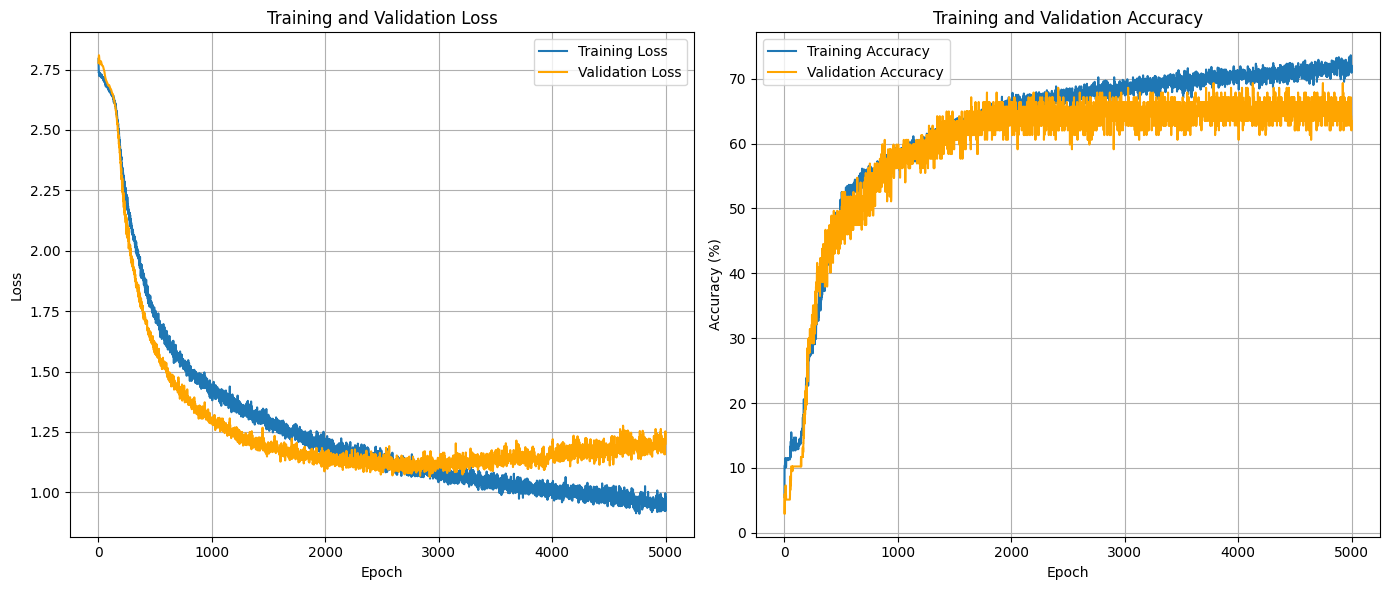

Execution time: 295.3553 seconds


In [34]:
start_time = time.time()
train(model, train_loader, optimizer, criterion, num_epochs, val_loader=val_loader, val_interval=1, print_interval=500)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.4f} seconds")

In [35]:
test_accuracy = evaluate(model, test_loader, criterion=criterion, accuracy=True)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 56.49%


### Visualitzation of MLP results

In [36]:
model.eval()

y_pred = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        
        # Get decoded predictions and labels 
        _, predictions = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1) 

        y_pred.extend(predictions.numpy())
        y_test.extend(labels.numpy())

y_pred = np.array(y_pred)
y_test = np.array(y_test)

In [37]:
xd_pred, yd_pred = decode(y_pred) 
xd_test, yd_test = decode(y_test)

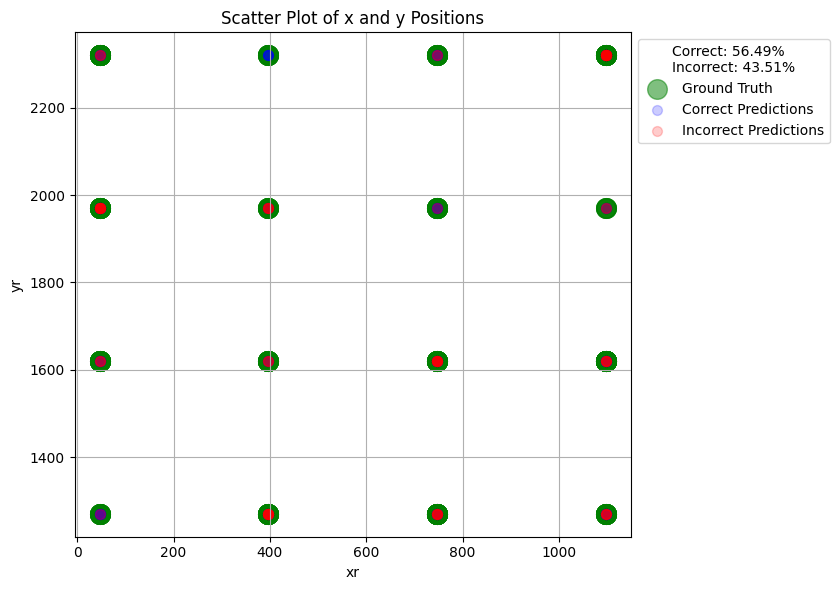

In [40]:
single_plot(xd_pred, yd_pred)
single_plot(xd_test, yd_test)
combined_plot(xd_pred, yd_pred, xd_test, yd_test)

### Learning without Duplicates

In [51]:
# get the number of AP in the trainig data
num_classes = len(set(y))

X_train, X_test, y_train, y_test = train_test_split(x_nond_data_rs, y_nond_data_rs, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# transform the data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

y_train_one_hot = F.one_hot(torch.tensor(y_train.to_numpy(), dtype=torch.long), num_classes=num_classes).float()
y_test_one_hot = F.one_hot(torch.tensor(y_test.to_numpy(), dtype=torch.long), num_classes=num_classes).float()
y_val_one_hot = F.one_hot(torch.tensor(y_val.to_numpy(), dtype=torch.long), num_classes=num_classes).float()

# Create the new torch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_one_hot)
test_dataset = TensorDataset(X_test_tensor, y_test_one_hot)
val_dataset = TensorDataset(X_val_tensor, y_val_one_hot)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [56]:
input_size = X_train_tensor.shape[1]
output_size = y_train_one_hot.shape[1]
model = MLP(input_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 500/5000, Training Loss: 0.8788
Validation Loss: 1.1306
Validation Accuracy: 69.72%


Epoch 1000/5000, Training Loss: 0.6389
Validation Loss: 1.1151
Validation Accuracy: 70.64%


Epoch 1500/5000, Training Loss: 0.5288
Validation Loss: 1.1016
Validation Accuracy: 77.06%


Epoch 2000/5000, Training Loss: 0.4909
Validation Loss: 1.1432
Validation Accuracy: 75.23%


Epoch 2500/5000, Training Loss: 0.4196
Validation Loss: 1.1719
Validation Accuracy: 76.15%


Epoch 3000/5000, Training Loss: 0.3770
Validation Loss: 1.2261
Validation Accuracy: 74.31%


Epoch 3500/5000, Training Loss: 0.3610
Validation Loss: 1.2861
Validation Accuracy: 77.06%


Epoch 4000/5000, Training Loss: 0.3311
Validation Loss: 1.3666
Validation Accuracy: 75.23%


Epoch 4500/5000, Training Loss: 0.3167
Validation Loss: 1.3973
Validation Accuracy: 74.31%


Epoch 5000/5000, Training Loss: 0.3048
Validation Loss: 1.4847
Validation Accuracy: 76.15%


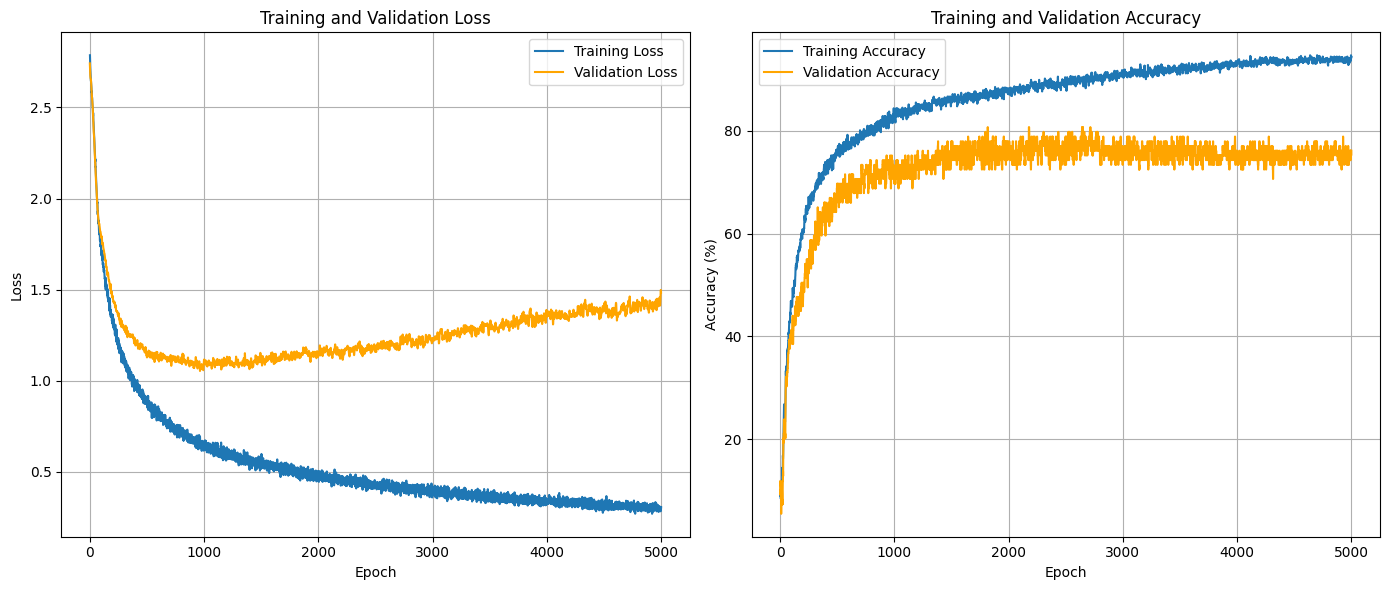

Execution time: 256.5358 seconds


In [62]:
start_time = time.time()
train(model, train_loader, optimizer, criterion, num_epochs, val_loader=val_loader, val_interval=1, print_interval=500)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.4f} seconds")

In [63]:
test_accuracy = evaluate(model, test_loader, criterion=criterion, accuracy=True)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 70.93%


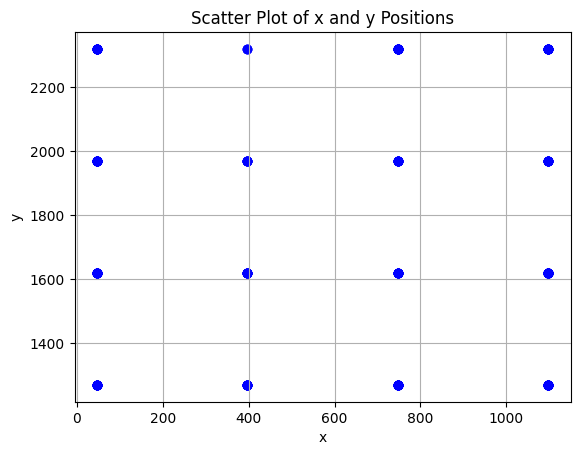

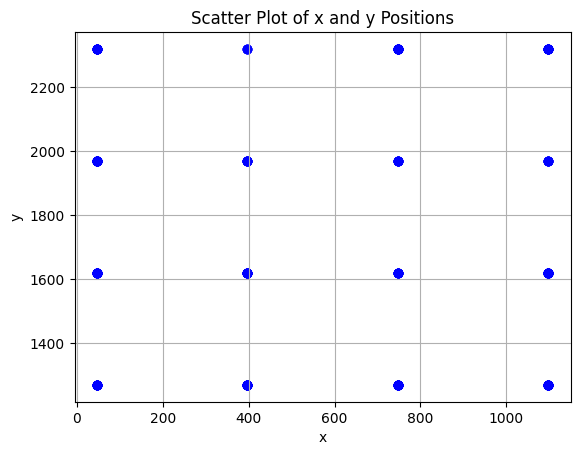

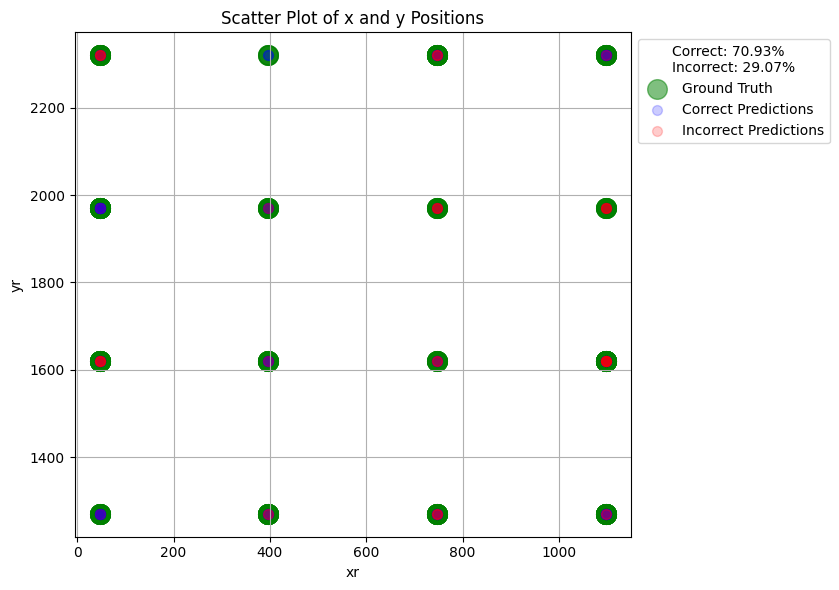

In [64]:
model.eval()

y_pred = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        
        # Get decoded predictions and labels 
        _, predictions = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1) 

        y_pred.extend(predictions.numpy())
        y_test.extend(labels.numpy())

y_pred = np.array(y_pred)
y_test = np.array(y_test)


xd_pred, yd_pred = decode(y_pred) 
xd_test, yd_test = decode(y_test)

single_plot(xd_pred, yd_pred)
single_plot(xd_test, yd_test)
combined_plot(xd_pred, yd_pred, xd_test, yd_test)

## Using (xr, yr) Locations

In [77]:
## Load data
path = 'data/full_rss_d1_v2.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0'])

data = data.drop(columns=['Long', 'Lat'])

data.replace({np.nan: 100}, inplace=True)

X = data.iloc[:, :-1] 
y = data.iloc[:, -2:]  

## scale data
robust_scaled_data = RobustScaler().fit_transform(X)

## create datasets
dataset = CustomDataset(robust_scaled_data, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

X_train, X_test, y_train, y_test = train_test_split(log_transofmed_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)


# Create the new torch dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)


In [79]:
# Model parameters
batch_size = 256
num_epochs = 5000
learning_rate= 0.001

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [80]:
## Model 

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 2) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.relu(self.hidden3(x))
        x = self.output(x)  # No activation for regression 
        return x


In [82]:
model = MLP(X_train.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 500/5000, Training Loss: 167653.4492
Validation Loss: 152126.6875
Validation MSE: 152126.6875


Epoch 1000/5000, Training Loss: 170388.1641
Validation Loss: 149058.8438
Validation MSE: 149058.8438


Epoch 1500/5000, Training Loss: 166791.4062
Validation Loss: 144381.8750
Validation MSE: 144381.8750


Epoch 2000/5000, Training Loss: 157747.6445
Validation Loss: 137999.0938
Validation MSE: 137999.0938


Epoch 2500/5000, Training Loss: 150751.4062
Validation Loss: 136074.1719
Validation MSE: 136074.1719


Epoch 3000/5000, Training Loss: 143340.1445
Validation Loss: 141625.2188
Validation MSE: 141625.2188


Epoch 3500/5000, Training Loss: 139513.3359
Validation Loss: 142162.4062
Validation MSE: 142162.4062


Epoch 4000/5000, Training Loss: 133979.0820
Validation Loss: 137725.0469
Validation MSE: 137725.0469


Epoch 4500/5000, Training Loss: 130778.8301
Validation Loss: 139752.0000
Validation MSE: 139752.0000


Epoch 5000/5000, Training Loss: 128028.8633
Validation Loss: 146862.2031
Validation MSE: 146862.2031


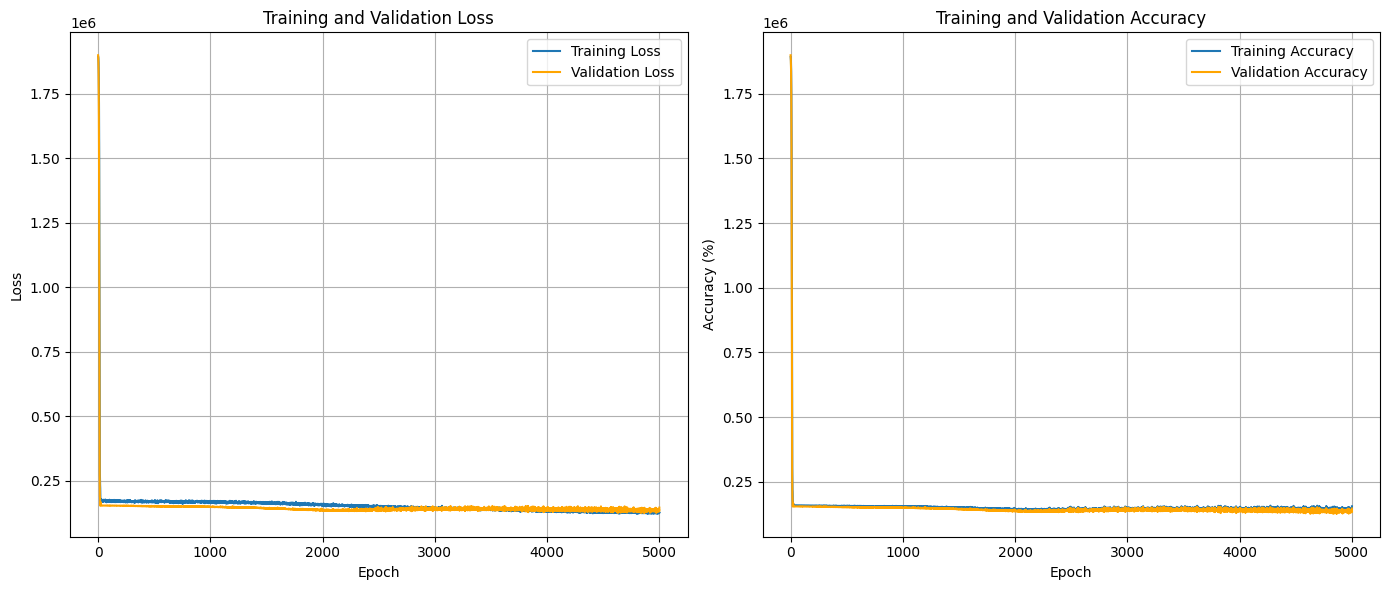

Execution time: 360.2723 seconds


In [83]:
start_time = time.time()
train(model, train_loader, optimizer, criterion, num_epochs, val_loader=val_loader, val_interval=1, print_interval=500)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.4f} seconds")

### Regression with XGBoost (xr. yr)

In [87]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_x = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
model_y = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

model_x.fit(X_train, y_train[:, 0])
model_y.fit(X_train, y_train[:, 1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [88]:
# Make predictions
y_pred_x = model_x.predict(X_test)
y_pred_y = model_y.predict(X_test)

# Evaluate the models
mse_x = mean_squared_error(y_test[:, 0], y_pred_x)
mse_y = mean_squared_error(y_test[:, 1], y_pred_y)

print(f'Mean Squared Error for x predictions: {mse_x}')
print(f'Mean Squared Error for y predictions: {mse_y}')


Mean Squared Error for x predictions: 111574.9296875
Mean Squared Error for y predictions: 67023.921875
